# Extension

## 1) Data preparation

###  A) Load datasets

First we will load all the dataset we need. We load the 2015 ward Tesco 1.0 dataset and the official London ward 2015 dataset.

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
root = "data/"
tesco_msoa_path = os.path.join(root,"year_msoa_grocery.csv")
msoa_profile_path = os.path.join(root,"msoa-data.csv")

In [3]:
tesco_msoa_df = pd.read_csv(tesco_msoa_path)
msoa_profile_df = pd.read_csv(msoa_profile_path,encoding = "ISO-8859-1")

In [4]:
tesco_msoa_df.head(5)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,103934,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,9952,7379.0,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,19576,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794
3,E02000004,347.481292,29.0,126.0,250.0,430.0,1000.0,479.372575,5.297349,104.435407,...,10689,6536.0,3119.0,3417.0,1454.0,4044.0,1038.0,38.493115,2.48,2635.483871
4,E02000005,400.576688,32.5,150.0,296.0,500.0,1050.0,593.021809,5.107669,128.997438,...,15071,9243.0,4478.0,4765.0,2678.0,5554.0,1011.0,34.156335,1.19,7767.226891


In [5]:
tesco_msoa_df.shape

(983, 202)

In paper dataset, we have 201 nutrition related features and 983 msoa areas.

In [6]:
msoa_profile_df.head(2)

,Middle Super Output Area,MSOA Name,Age Structure (2011 Census);All Ages;,Age Structure (2011 Census);0-15;,Age Structure (2011 Census);16-29;,Age Structure (2011 Census);30-44;,Age Structure (2011 Census);45-64;,Age Structure (2011 Census);65+;,Age Structure (2011 Census);Working-age;,Mid-year Estimate totals;All Ages;2002,...,Road Casualties;2010;Slight,Road Casualties;2010;2010 Total,Road Casualties;2011;Fatal,Road Casualties;2011;Serious,Road Casualties;2011;Slight,Road Casualties;2011;2011 Total,Road Casualties;2012;Fatal,Road Casualties;2012;Serious,Road Casualties;2012;Slight,Road Casualties;2012;2012 Total
0,E02000001,City of London 001,7375,620,1665,2045,2010,1035,5720,7280,...,334,374,0,46,359,405,2,51,361,414
1,E02000002,Barking and Dagenham 001,6775,1751,1277,1388,1258,1101,3923,6333,...,18,18,0,2,16,18,0,1,15,16


In [7]:
msoa_profile_df.shape

(984, 207)

In official ward dataset, we have 207 different features about official statistics of each ward. We observe there are 984 msoa areas.

Now we will load geographic data of wards for geovisualization.

In [8]:
msoa_map_path = os.path.join(root,"London","ESRI","MSOA_2011_London_gen_MHW.shp")
msoa_map_df = gpd.read_file(msoa_map_path)
msoa_map_df.head(5)

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18..."
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((551549.998 187364.637, 551478.000 18..."
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((549099.634 187656.076, 549161.375 18..."


In [9]:
msoa_map_df.shape

(983, 13)

This dataset presents the localization of 983 msoa areas.

<AxesSubplot:>

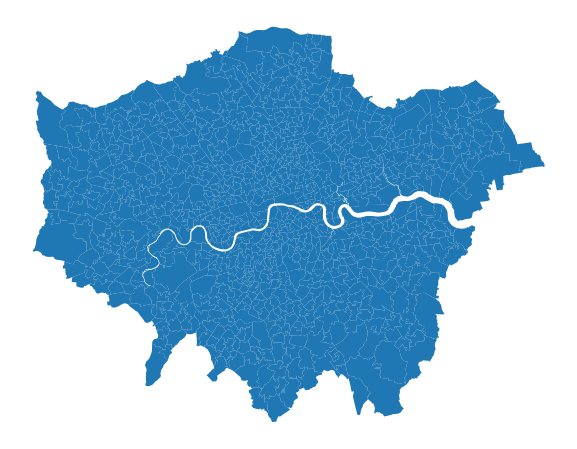

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.axis("off")
msoa_map_df.plot(ax=ax)

### B) Prepare datasets

We choose the median because it has a better representativeness than the mean.

In [11]:
official_useful_features = ["Household Income Estimates (2011/12);Total Median Annual Household Income (£);",
                            "Middle Super Output Area"]
main_df = tesco_msoa_df.merge(msoa_profile_df[official_useful_features],
                              left_on="area_id",right_on="Middle Super Output Area")
main_df.head(5)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,Household Income Estimates (2011/12);Total Median Annual Household Income (£);,Middle Super Output Area
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069,46788,E02000001
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704,27059,E02000002
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794,36835,E02000003
3,E02000004,347.481292,29.0,126.0,250.0,430.0,1000.0,479.372575,5.297349,104.435407,...,3119.0,3417.0,1454.0,4044.0,1038.0,38.493115,2.48,2635.483871,39668,E02000004
4,E02000005,400.576688,32.5,150.0,296.0,500.0,1050.0,593.021809,5.107669,128.997438,...,4478.0,4765.0,2678.0,5554.0,1011.0,34.156335,1.19,7767.226891,29156,E02000005


In [12]:
main_df.shape

(983, 204)

## 2) Visualization